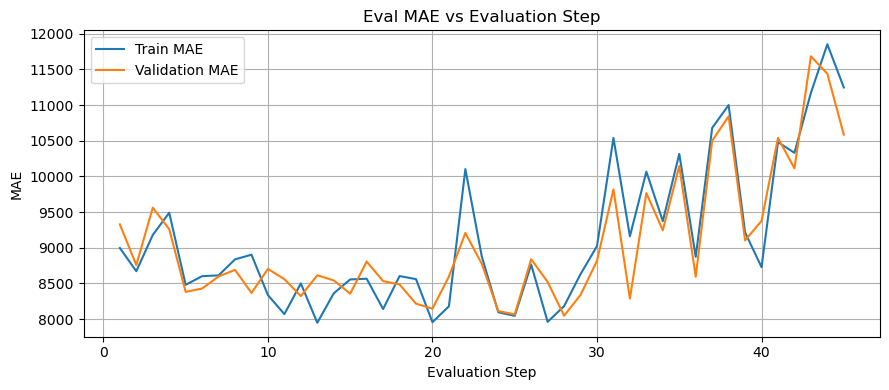

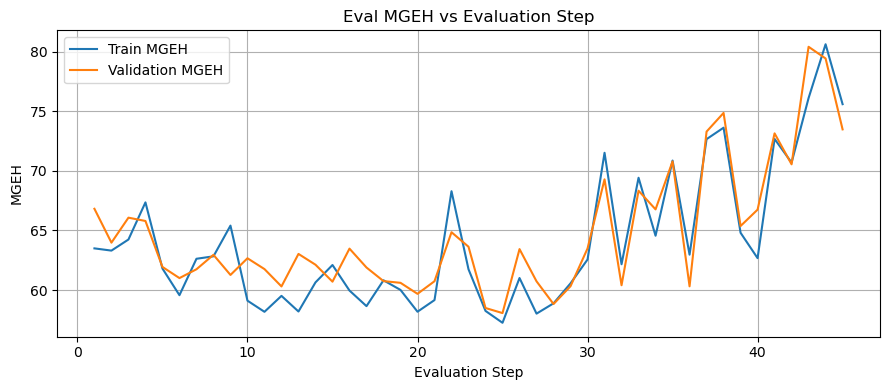

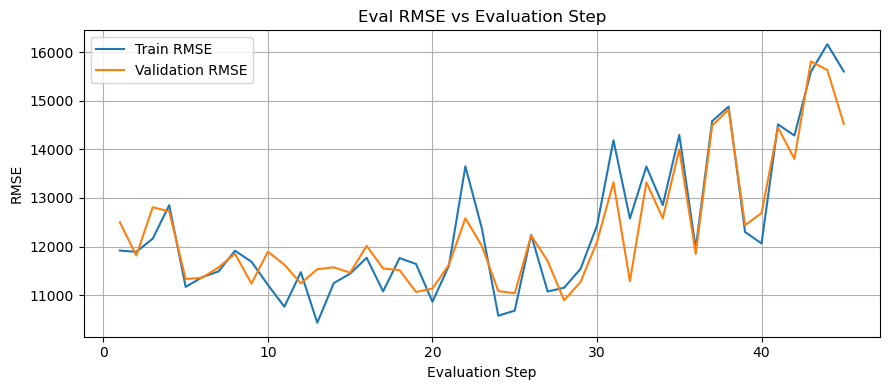

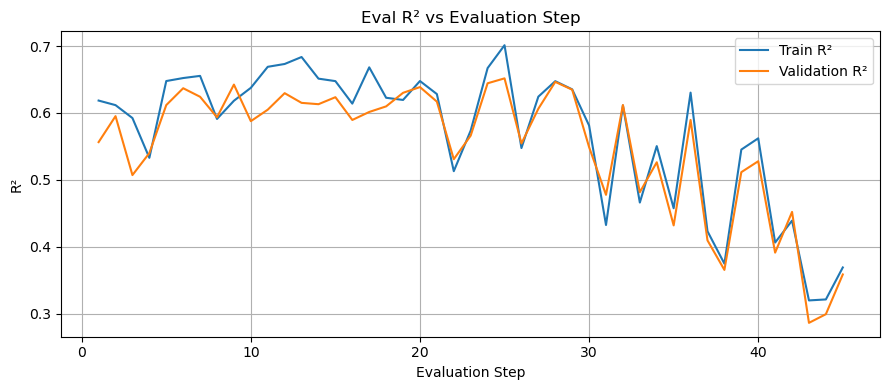

In [2]:
import re
import matplotlib.pyplot as plt
from pathlib import Path

LOG_PATH = Path("logs/projection.log")  # updated to match the new trainer

if not LOG_PATH.exists():
    raise FileNotFoundError(f"Log file not found: {LOG_PATH}")

log_text = LOG_PATH.read_text(encoding="utf-8", errors="ignore")

# ---------------------------------------
# Robust float pattern (handles 1.23, -4., .5, 1e-3, -2.1E+05)
# ---------------------------------------
FLOAT = r"[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?"

# ---------------------------------------
# Regex patterns (use NAMED GROUPS to avoid index mistakes)
# Train/Val lines now use RMSE and include R2; val lines may add "(stage S/T, lr=...)".
# ---------------------------------------
pattern_train = re.compile(
    rf"Epoch\s+(?P<epoch>\d+)\s+Step\s+(?P<step>\d+)\s+Train\s+Eval:\s*"
    rf"RMSE:\s*(?P<rmse>{FLOAT}),\s*MAE:\s*(?P<mae>{FLOAT}),\s*MGEH:\s*(?P<mgeh>{FLOAT}),\s*R2:\s*(?P<r2>{FLOAT})",
    re.IGNORECASE
)

pattern_val = re.compile(
    rf"Epoch\s+(?P<epoch>\d+)\s+Step\s+(?P<step>\d+)\s+Validation\s+Eval:\s*"
    rf"RMSE:\s*(?P<rmse>{FLOAT}),\s*MAE:\s*(?P<mae>{FLOAT}),\s*MGEH:\s*(?P<mgeh>{FLOAT}),\s*R2:\s*(?P<r2>{FLOAT})"
    rf"(?:\s*\(stage\s+(?P<stage_cur>\d+)\s*/\s*(?P<stage_total>\d+)\s*,\s*lr\s*=\s*(?P<lr>{FLOAT})\s*\))?",
    re.IGNORECASE
)

# ---------------------------------------
# Containers
# ---------------------------------------
train_steps, train_rmse, train_mae, train_mgeh, train_r2 = [], [], [], [], []
val_steps, val_rmse, val_mae, val_mgeh, val_r2 = [], [], [], [], []
val_stage_idx, val_lr = [], []

# ---------------------------------------
# Parse Train Eval lines
# ---------------------------------------
t_idx = 0
for m in pattern_train.finditer(log_text):
    t_idx += 1
    g = m.groupdict()
    train_steps.append(t_idx)
    train_rmse.append(float(g["rmse"]))
    train_mae.append(float(g["mae"]))
    train_mgeh.append(float(g["mgeh"]))
    train_r2.append(float(g["r2"]))

# ---------------------------------------
# Parse Validation Eval lines
# ---------------------------------------
v_idx = 0
for m in pattern_val.finditer(log_text):
    v_idx += 1
    g = m.groupdict()
    val_steps.append(v_idx)
    val_rmse.append(float(g["rmse"]))
    val_mae.append(float(g["mae"]))
    val_mgeh.append(float(g["mgeh"]))
    val_r2.append(float(g["r2"]))

    # Optional fields (stage/lr)
    stage_val = int(g["stage_cur"]) if g["stage_cur"] is not None else None
    lr_val = float(g["lr"]) if g["lr"] is not None else None
    val_stage_idx.append(stage_val)
    val_lr.append(lr_val)

# ---------------------------------------
# Helper: find indices where LR stage changes (for vertical lines)
# ---------------------------------------
def stage_change_indices(stages):
    idxs = []
    prev = None
    for i, s in enumerate(stages, start=1):
        if s is None:
            continue
        if prev is None:
            prev = s
            continue
        if s != prev:
            idxs.append(i)
            prev = s
    return idxs

stage_boundaries = stage_change_indices(val_stage_idx)

# ---------------------------------------
# Plot MAE curve
# ---------------------------------------
if train_steps or val_steps:
    plt.figure(figsize=(9, 4))
    if train_steps:
        plt.plot(train_steps, train_mae, label="Train MAE")
    if val_steps:
        plt.plot(val_steps, val_mae, label="Validation MAE")
        for sb in stage_boundaries:
            plt.axvline(sb, linestyle="--", alpha=0.5)
    plt.title("Eval MAE vs Evaluation Step")
    plt.xlabel("Evaluation Step")
    plt.ylabel("MAE")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # ---------------------------------------
    # Plot MGEH curve
    # ---------------------------------------
    plt.figure(figsize=(9, 4))
    if train_steps:
        plt.plot(train_steps, train_mgeh, label="Train MGEH")
    if val_steps:
        plt.plot(val_steps, val_mgeh, label="Validation MGEH")
        for sb in stage_boundaries:
            plt.axvline(sb, linestyle="--", alpha=0.5)
    plt.title("Eval MGEH vs Evaluation Step")
    plt.xlabel("Evaluation Step")
    plt.ylabel("MGEH")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # ---------------------------------------
    # (Optional) Plot RMSE and R2 as well
    # ---------------------------------------
    if train_rmse or val_rmse:
        plt.figure(figsize=(9, 4))
        if train_steps:
            plt.plot(train_steps, train_rmse, label="Train RMSE")
        if val_steps:
            plt.plot(val_steps, val_rmse, label="Validation RMSE")
            for sb in stage_boundaries:
                plt.axvline(sb, linestyle="--", alpha=0.5)
        plt.title("Eval RMSE vs Evaluation Step")
        plt.xlabel("Evaluation Step")
        plt.ylabel("RMSE")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    if train_r2 or val_r2:
        plt.figure(figsize=(9, 4))
        if train_steps:
            plt.plot(train_steps, train_r2, label="Train R²")
        if val_steps:
            plt.plot(val_steps, val_r2, label="Validation R²")
            for sb in stage_boundaries:
                plt.axvline(sb, linestyle="--", alpha=0.5)
        plt.title("Eval R² vs Evaluation Step")
        plt.xlabel("Evaluation Step")
        plt.ylabel("R²")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
else:
    print("No Eval lines found in log.")

In [67]:
val_mgeh

[27.11524, 28.646282, 28.599636, 26.260391, 25.157822, 25.181618]